In [1]:
import time

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Links

### Sections

1. [Preprocessing](#prep)
1. [Statistical study](#comp)
    1. [Linear regression](#comp)
    4. [Results](#rhl)
    5. [Comparison of coefficients for groups](#summary)
2. [Predictive performance](#pf)
    1. [Linear regression](#linreg)
    2. [Random Forest](#rf)
5. [Clustering](#clust)
6. [APPENDIX](#apdx)
    1. [Regularisation](#l2)
    2. [RF predictor importance](#imp)
    3. [Automatic variable selection](#selec)

### Answers to:

* [Question #1](#q1)
* [Question #2](#q2)
* [Question #3](#q3)
* [Question #4](#q4)
* [Question #5](#q5)
* [Question #6](#q6)


## Loading data

In [2]:
df = pd.read_excel('./All 3Run_MainVarOnly_Compiled_5.3.16.xlsx')  # Load data
df = df.ix[:352, :]  # Last rows look too suspicious???

Let's only keep interesting variables.

In [3]:
## Study score gain
target = 'TotalGain'

predictors_v1 = ['HighestLevelCompleted', 'Gender', 'Grade',
        'AverageScrGEQ', 'AverageScrMyEng.', 'AvrgInc.Time', 
        'AvrgTotalTrialAllLvls', 'TotalPre',
        'L and S SWM Data (Avrg.) or just L (Jan-Fre)',
        'LSANTAcc', ' LSMeanNeutralRT', 'LSExecScore', 
         'LSOrientScore', 'LSAlertScore', 'LSOrientComboNoIncomp']

predictors_v2 = ['HighestLevelCompleted',
        'AvrgInc.Time', 'AvrgTotalTrialAllLvls', 'TotalPre',
        'L and S SWM Data (Avrg.) or just L (Jan-Fre)', 'LSANTAcc']

## Study HighestLevel (Uncomment if wanted)
# target = 'HighestLevelCompleted'

# predictors_v1 = ['TotalGain', 'Gender', 'Grade',
#         'AverageScrGEQ', 'AverageScrMyEng.', 'AvrgInc.Time', 
#         'AvrgTotalTrialAllLvls', 'TotalPre',
#         'L and S SWM Data (Avrg.) or just L (Jan-Fre)',
#         'LSANTAcc', ' LSMeanNeutralRT', 'LSExecScore', 
#          'LSOrientScore', 'LSAlertScore', 'LSOrientComboNoIncomp']

# predictors_v2 = ['TotalGain', 'AvrgInc.Time', 'AvrgTotalTrialAllLvls', 
#                  'TotalPre', 'L and S SWM Data (Avrg.) or just L (Jan-Fre)',
#                  'LSANTAcc']

predictors = predictors_v2

In [4]:
df['Gender'] = df['Gender'].astype('category')
df['Grade'] = df['Grade'].astype('category')

X = pd.get_dummies(df[predictors], drop_first=True)
y = df[target].values

In [5]:
variables = list(X.columns)
X.head()

,HighestLevelCompleted,AvrgInc.Time,AvrgTotalTrialAllLvls,TotalPre,L and S SWM Data (Avrg.) or just L (Jan-Fre),LSANTAcc
0,31.0,368.060111,36.979826,3.0,0.666667,0.868056
1,53.0,491.155333,26.000000,4.0,NaN,0.909722
2,53.0,476.198727,12.500000,14.0,0.750000,0.902778
3,49.0,400.828154,3.000000,9.0,0.750000,NaN
4,53.0,499.495455,27.500000,13.0,0.904762,0.888889


## Preprocessing
<a id='prep'></a>

Let's have a first look at data distribution.

In [6]:
# Missing data
desc = X.describe()
count = desc.T['count']
print count

HighestLevelCompleted                           336.0
AvrgInc.Time                                    336.0
AvrgTotalTrialAllLvls                           326.0
TotalPre                                        352.0
L and S SWM Data (Avrg.) or just L (Jan-Fre)    262.0
LSANTAcc                                        234.0
Name: count, dtype: float64


/Users/arnaud/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


There are a few missing values in the dataset, especially on `LSANTAcc`, we will impute them using `sklearn.preprocessing.Imputer`.

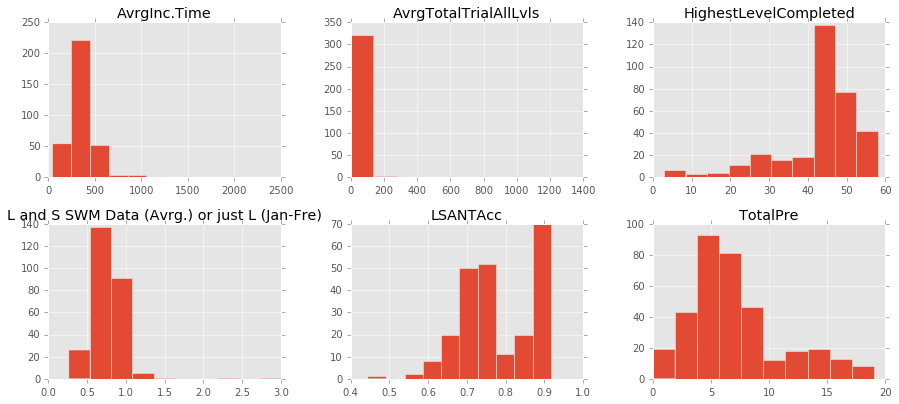

In [7]:
plt.figure()
X.hist(figsize=(15, 10), layout=(3, 3))
plt.show()

The distribution of values in the different predictor vary greatly. In particular, `AvrgInc.Time` and `AvrgTotalTrialAllLvls` have a much greater spead. We will rescale them using a log transform. This will help coefficients in the regression have comparable values.

In [8]:
X['AvrgTotalTrialAllLvls'] = np.log(X['AvrgTotalTrialAllLvls'] + 1)
X['AvrgInc.Time'] = np.log(X['AvrgInc.Time'] + 1)

In [9]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

In [10]:
X = Imputer(strategy='mean').fit_transform(X)
X = StandardScaler().fit_transform(X)

Let's now have a look at the preprocessed data.

/Users/arnaud/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


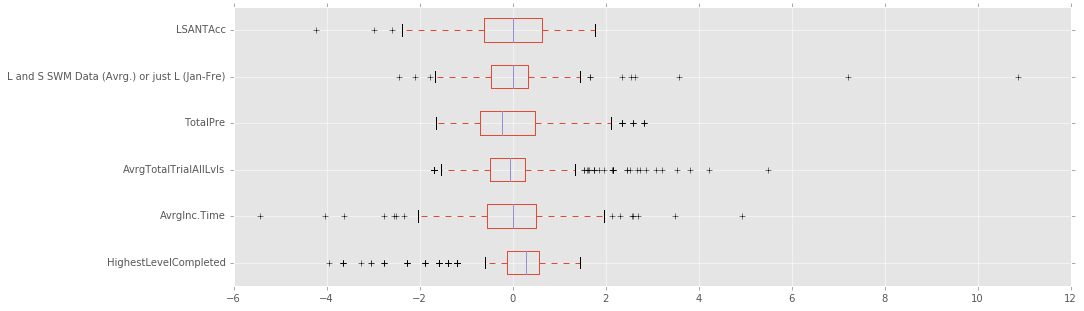

In [11]:
plt.figure(figsize=(15, 5))
pd.DataFrame(X, columns=predictors).boxplot(vert=False)
plt.show()

# Statistical comparison
<a id='comp'></a>

In the following, I fit a simple linear model to predict `TotalGain`. Although the independent variable might not be linearly dependent on the predictors it is a useful simplification that is easily interpretable. 

In [12]:
cond1_idx = df['Condition'].values == 1
cond2_idx = df['Condition'].values == 2

In [13]:
keep_idx = (cond1_idx & ~np.isnan(y))
y1 = y[keep_idx]
X1 = X[keep_idx, :]

keep_idx = (cond2_idx & ~np.isnan(y))
y2 = y[keep_idx]
X2 = X[keep_idx, :]

In [14]:
import statsmodels.api as sm

In [15]:
mod1 = sm.OLS(y1, X1)
res1 = mod1.fit()
print res1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     5.922
Date:                Wed, 25 May 2016   Prob (F-statistic):           1.21e-05
Time:                        23:37:36   Log-Likelihood:                -579.28
No. Observations:                 178   AIC:                             1171.
Df Residuals:                     172   BIC:                             1190.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.1755      0.536      2.193      0.0

In [16]:
mod2 = sm.OLS(y2, X2)
res2 = mod2.fit()
print res2.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.990
Date:                Wed, 25 May 2016   Prob (F-statistic):            0.00844
Time:                        23:37:36   Log-Likelihood:                -559.86
No. Observations:                 172   AIC:                             1132.
Df Residuals:                     166   BIC:                             1151.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.9838      0.538      1.828      0.0

## Interpretation of results
<a id='rtg'></a>

Both models have **poor predictive power** with an R2 score of `~0.15`.

There is also quite a bit of uncertainty on the coefficients of the regression. This makes it quite difficult to compare the two settings (`cond1` vs `cond2`). However, most coefficients are significant (null hypothesis is rejected) for `cond1` and several as well for `cond2`. 


Let's look at the value of coefficients anyway but keep in mind that the confidence intervals (@95%) overlap:

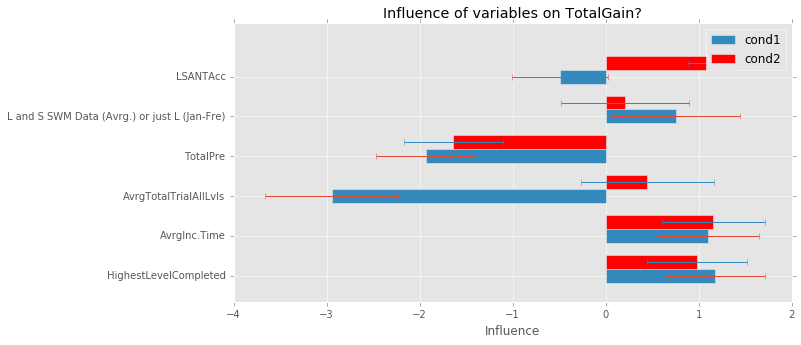

In [17]:
N = len(res1.params)
lab = variables
pos = np.arange(N) - 0.35
width = 0.35

plt.figure(figsize=(10, 5))
b1 = plt.barh(pos, res1.params, width, align='center', xerr=res1.bse)
b2 = plt.barh(pos + width, res2.params, width, color='r', align='center', xerr=res1.bse)
plt.yticks(pos, lab)
plt.xlabel('Influence')
plt.title('Influence of variables on TotalGain?')
plt.legend([b1, b2], ['cond1', 'cond2'])
plt.show()
assert(len(lab) == len(res1.params) == len(pos))

<a id='q2'></a>
> Question #2: Within each condition, does performance on gain score differ based on gender, grade level, engagement survey scores (Average SCR GEQ, Average SCrMy Eng), Inc. Time, Highest Level Completed, AvrgTotalTrialsAllsLvls, various LS variables, L and S SWM data?

It seems that `L and S SWM...`, `AvrgInc.Time` and `HighestLevelCompleted` all have a positive influence on `TotalGain` with comparable importance in both `cond1` and `cond2` settings.

`LSANTAcc` has postive influence in one setting and negative in the other surprisingly.

`TotalPre` and `AvrgTotalTrialAllLvls` seems to negatively impact learning.

<a id='q3'></a>
> Question #3: Within each condition, does performance on highest level completed differ based on gain score, gender, grade level, engagement survey scores (Average SCR GEQ, Average SCrMy Eng), Inc. Time, AvrgTotalTrialsAllsLvls, various LS variables, L and S SWM data?

This time again we observe the same trends as for predicting `TotalGain`. It seems that the uncertainty in the coefficients is less pronouced though.

*Note that the coefficient have not been centered and rescaled. This means that the value of the coefficient depends on the scale of the feature. Rescaling can be useful to see the relative importance of different independent variables.*

## Comparison of groups
<a id='summary'></a>

Here I try to answer question 1.:

<a id='q1'></a>
> Question #1: What conditions performed better?

Based on the relative gain in TotalGain or HighestLevel for each L and S... it seems that condition == 1 performed better. There is (reasonably?) relatively little overlap in the confidence intervals for these values. However these results should be looked at with caution.

If we compute `z-values` of the coefficients:

In [18]:
coeff1 = res1.params
std1 = res1.bse
n1 = X1.shape[0]

coeff2 = res2.params
std2 = res2.params
n2 = X2.shape[0]

tt = (coeff1 - coeff2) / np.sqrt(std1**2 + std2**2)

for t, var in zip(tt, variables):
    print "%s \t %.2f" % (var[:12], t)

HighestLevel 	 0.17
AvrgInc.Time 	 -0.04
AvrgTotalTri 	 -4.03
TotalPre 	 -0.17
L and S SWM  	 0.76
LSANTAcc 	 -1.27


<a id='q6'></a>
> Question #6: Esp. want to know if spatial ability/attentional ability (LS variables) related to gain score? or highest level completed, within conditions and comparing across them?

It seems the LS variables have a strong influence on learning progression. However I'm not sure the norm of this feature can be used as is. I can do centering and rescaling to see what is the relative importance of this factor.

<a id='q4'></a>
> Question #4: Are there interaction effects with the above variables that can explain differences across conditoins?

What would that mean? 

# Predictive performance
<a id='pf'></a>

## Linear Regression
<a id='linreg'></a>

Here we look at the linear model from a predictive performance point of view. We do not care about statistical significance of the coefficients but just about loss optimization.

In [19]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=0)

In [21]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
p_train = model.predict(X_train)
p_test = model.predict(X_test)

In [23]:
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score

print "Train MAE = %s" % mean_absolute_error(y_train, p_train)
print "Test MAE = %s" % mean_absolute_error(y_test, p_test)
print ""
print "Train EV = %s" % explained_variance_score(y_train, p_train)
print "Test EV = %s" % explained_variance_score(y_test, p_test)
print ""
print "Train R2 = %s" % r2_score(y_train, p_train)
print "Test R2 = %s" % r2_score(y_test, p_test)

Train MAE = 3.25845938798
Test MAE = 3.98306836369

Train EV = 0.165257611248
Test EV = 0.161159965483

Train R2 = 0.165257611248
Test R2 = 0.130068709936


Predictive performance of the linear regression is quite poor. This can be due to a lack of information about the outcome in the variables or to the fact that the are nonlinear dependencies. To test the second assumption we can try to fit a more complex model like RandomForest on the data.

## Random Forest
<a id='rf'></a>

Now I test a nonlinear model to see if there may be more information in the data that cannot be model by a linear dependency.

In [24]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [25]:
model = RandomForestRegressor()
alphas = np.arange(0.001, 10, .1)
tuned_parameters = [{'n_estimators': range(1, 21)}]

In [26]:
# score = 'mean_squared_error'
score = 'r2'
#score = 'mean_absolute_error'

I do a cross validation on the number of trees in the forest just for fun and because it is cheap and fast.

In [27]:
clf = GridSearchCV(model, tuned_parameters, cv=10, scoring=score)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [28]:
rf = clf.best_estimator_

In [29]:
y_pred = rf.predict(X_test)

print "MAE = %s" % mean_absolute_error(y_test, y_pred)
print "EV = %s" % explained_variance_score(y_test, y_pred)
print "R2 = %s" % r2_score(y_test, y_pred)

MAE = 3.83333333333
EV = 0.193319784628
R2 = 0.172729492188


**In that case, RandomForest actually seems to perform worse that LinearRegression!!!**

Variable importance seems to be a bit different when taking into account nonlinear dependencies.

# Clustering
<a id='clust'></a>

In [30]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

Here we use manifold learning to see if there is some kind of structure in the data. More specifically we use t-SNE to project it on a 2D manifold for simpler visualization.

In [31]:
use = ['L and S SWM Data (Avrg.) or just L (Jan-Fre)', u'LSANTAcc', 'TotalPre', 
       'TotalGain', 'HighestLevelCompleted', 'TotalTrialsAllLvls', 'AverageScrGEQ']

In [32]:
use = predictors + [target]
X = pd.get_dummies(df[use], drop_first=True)
 
X = Imputer(strategy='mean').fit_transform(X)
X = StandardScaler().fit_transform(X)

In [33]:
reduced_data = TSNE(n_components=2, random_state=0).fit_transform(X)

In [34]:
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit(reduced_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=7, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

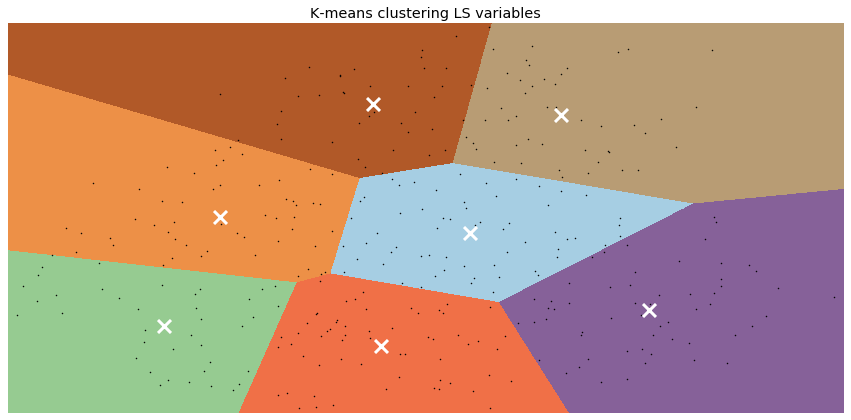

In [35]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(15, 7))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering LS variables')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

<a id='q5'></a>
> Question #5: Do these variables have clustering efffects?

A priori, it will be quite hard to automatically find meaningfull clusters. There seem to be a few outliers but apart from them t-SNE reveals no structure in the data. However we can still look at the semantic structure present in the clusters returned by KMeans.

In [36]:
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit(X)
pred = kmeans.predict(X)

In [37]:
xx = pd.DataFrame(X, columns=use)
xx['cluster'] = pred

In [38]:
for clust in np.unique(xx['cluster']):
    print xx.ix[xx['cluster'] == clust, :].describe().ix['mean', :]
    print ""

HighestLevelCompleted                           0.647590
AvrgInc.Time                                    0.390478
AvrgTotalTrialAllLvls                           0.024611
TotalPre                                        1.758631
L and S SWM Data (Avrg.) or just L (Jan-Fre)    0.252068
LSANTAcc                                       -0.122825
TotalGain                                      -0.336655
cluster                                         0.000000
Name: mean, dtype: float64

HighestLevelCompleted                          -2.368098
AvrgInc.Time                                    1.363193
AvrgTotalTrialAllLvls                          -0.000772
TotalPre                                       -0.502363
L and S SWM Data (Avrg.) or just L (Jan-Fre)    0.016688
LSANTAcc                                        0.235589
TotalGain                                       0.211308
cluster                                         1.000000
Name: mean, dtype: float64

HighestLevelCompleted           

# APPENDIX

## 1. Validation curve of regression with l2 penalty
<a id='l2'></a>

In [39]:
from sklearn.learning_curve import validation_curve
from sklearn.linear_model import Ridge

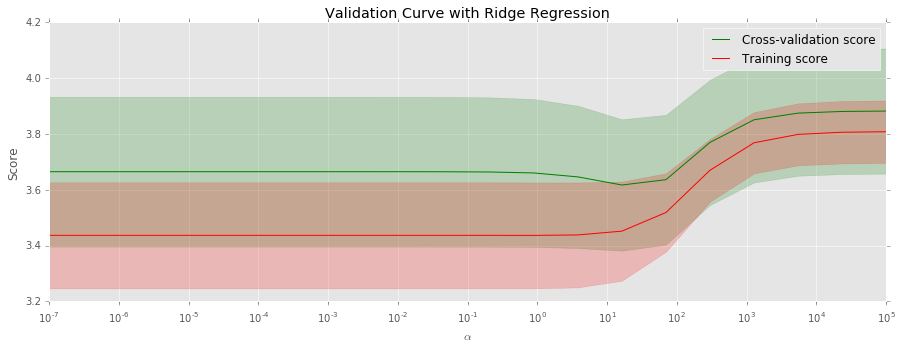

In [40]:
param_range = np.logspace(-7, 5, 20)
train_scores, test_scores = validation_curve(Ridge(), X1, y1, "alpha", param_range, scoring="mean_absolute_error")

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15, 5))
plt.title("Validation Curve with Ridge Regression")
plt.xlabel(r"$\alpha$")
plt.ylabel("Score")

plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")

plt.legend(loc="best")
plt.show()

Adding a penalty does not seems to make much of a difference.

# 2. Random Forest variable importance

Let's look at [variable importance](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) according to the RandomForest.

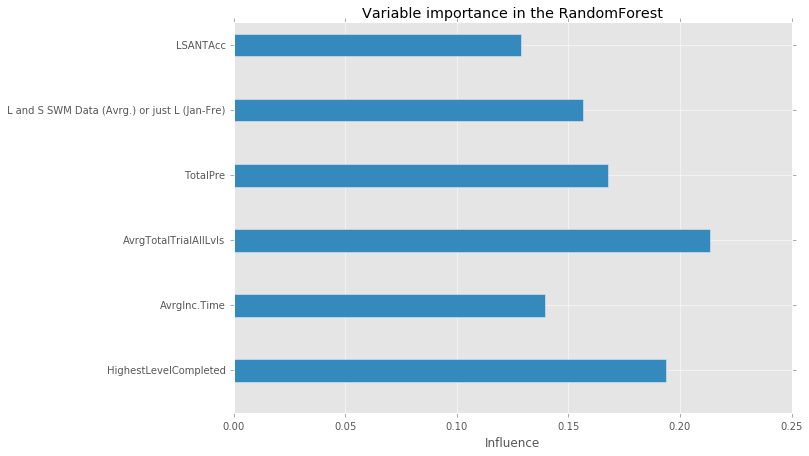

In [41]:
N = len(rf.feature_importances_)
lab = variables
pos = np.arange(N) - 0.35
width = 0.35

plt.figure(figsize=(10, 7))
b1 = plt.barh(pos, rf.feature_importances_, width, align='center')
plt.yticks(pos, lab)
plt.xlabel('Influence')
plt.title('Variable importance in the RandomForest')
plt.show()
assert(len(lab) == len(rf.feature_importances_) == len(pos))

<a id='selec'></a>
# 3. Automatic variable selection

In [42]:
predictors = ['HighestLevelCompleted', 'Gender', 'Grade',
        'AverageScrGEQ', 'AverageScrMyEng.', 'AvrgInc.Time', 
        'AvrgTotalTrialAllLvls', 'TotalPre',
        'L and S SWM Data (Avrg.) or just L (Jan-Fre)',
        'LSANTAcc', ' LSMeanNeutralRT', 'LSExecScore', 
         'LSOrientScore', 'LSAlertScore', 'LSOrientComboNoIncomp']

df['Gender'] = df['Gender'].astype('category')
df['Grade'] = df['Grade'].astype('category')

X = pd.get_dummies(df[predictors], drop_first=True)
y = df[target].values

X['AvrgTotalTrialAllLvls'] = np.log(X['AvrgTotalTrialAllLvls'] + 1)
X['AvrgInc.Time'] = np.log(X['AvrgInc.Time'] + 1)

keep_idx = (cond1_idx & ~np.isnan(y))
yy = y[keep_idx]
XX = X.ix[keep_idx, :]

In [43]:
XX = Imputer(strategy='mean').fit_transform(XX)
XX = StandardScaler().fit_transform(XX)

In [44]:
from sklearn.linear_model import LassoCV

In [45]:
reg = LassoCV(cv=100)

In [46]:
t1 = time.time()
reg.fit(XX, yy)
t_lasso_cv = time.time() - t1
print "Done in %.2f sec." % t_lasso_cv

Done in 0.48 sec.


In [47]:
m_log_alphas = -np.log10(reg.alphas_)

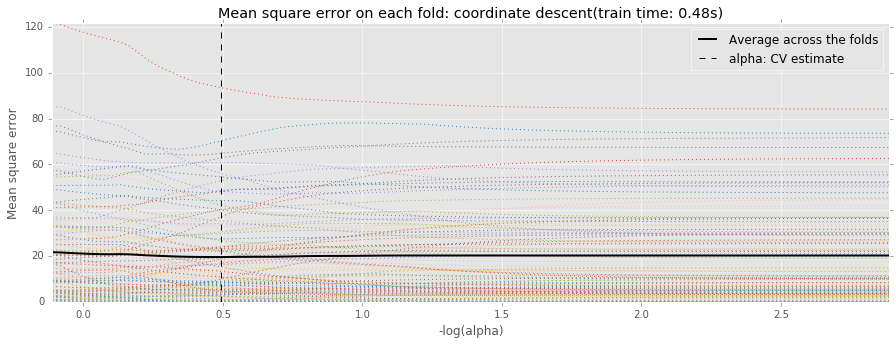

In [48]:
plt.figure(figsize=(15, 5))
plt.plot(m_log_alphas, reg.mse_path_, ':')
plt.plot(m_log_alphas, reg.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(reg.alpha_), linestyle='--', color='k', label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent'
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.show()

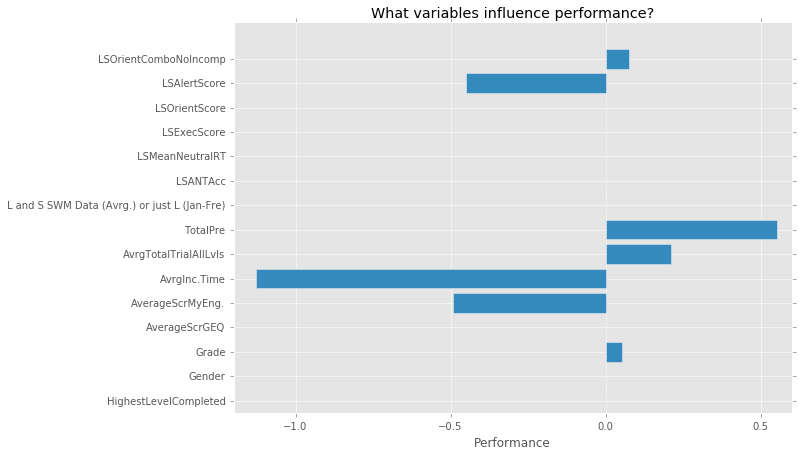

In [49]:
lab = predictors
pos = np.arange(len(reg.coef_)) + .5

plt.figure(figsize=(10, 7))
plt.barh(pos, reg.coef_, align='center')
plt.yticks(pos, lab)
plt.xlabel('Performance')
plt.title('What variables influence performance?')
plt.show()
assert(len(lab) == len(reg.coef_) == len(pos))